In [192]:
import os
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io import sql
import MySQLdb
import pandas.io.sql as psql
import tensorflow as tf
import time
import collections
import datetime
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import warnings

#pip install mysqlclient 
#!pip install -q -U keras-tuner

In [196]:
maus = pd.read_csv("maus_sample.csv")
transactions = pd.read_csv("transactions_sample.csv")
members = pd.read_csv("members_sample.csv")


# Data Modelling

I will develop a Machine Learning algorithm to predict whether or not if a member will do a transaction.
I didn't keep most of the dates column, i choose to work mostly on the values of members dataframe and their activity.

### Transactions Data Cleaning 

In [197]:
transactions = transactions.drop(columns=['latestReceipt','validated','receipt','otherMemberID', 'attempts','transactionID','actioned','optionalAttributes'])
transactions.loc[transactions['productID'].str.contains('weekly|WEEKLY',na=False), 'productID'] = 'Weekly Premium'
transactions.loc[transactions['productID'].str.contains('monthly',na=False), 'productID'] = 'Monthly Premium'
transactions.loc[transactions['productID'].str.contains('quarterly',na=False), 'productID'] = 'Quarterly Premium'
transactions.loc[transactions['productID'].str.contains('biannually',na=False), 'productID'] = 'Biannually Premium'
transactions.loc[transactions['productID'].str.startswith('annually',na=False),'productID'] = 'Annually Premium'
transactions.loc[transactions['productID'].str.startswith('10_instants',na=False),'productID'] = '10 instants'
transactions.loc[transactions['productID'].str.startswith('1_instant',na=False),'productID'] = '1 instant'
transactions.loc[transactions['productID'].str.startswith('5_instants',na=False),'productID'] = '5 instants'

transactions["productID"].value_counts()

Monthly Premium             16454
instant_match               10095
change_swipe                 5296
Weekly Premium               4353
1 instant                    2377
Quarterly Premium            1633
reset_swipes                  411
ten_swipes                    371
two_hundred_fifty_swipes      317
10 instants                   310
5 instants                    287
Annually Premium              281
fifty_swipes                  275
unblock_member                176
one_hundred_swipes            159
instant_match_bundle_4        154
instant_match_bundle_10       152
Biannually Premium            124
four_hundred_swipes            72
Name: productID, dtype: int64

In [198]:
transfreq = transactions.groupby(['memberID']).count()
transcount = transfreq[['id']] 
transcount = transcount.rename(columns={"id": "Transactions_count"})
transcount['Transaction']=1
#transactions.isna().sum()
#transfreq['productID'].sort_values()
#transfreq['productID'].value_counts()

### Members Data Cleaning 

In [199]:
m = {'M': 1, 'F': 0}
#members["gender"].map(m)
manalytics = members[['memberID','ipAddressCountryCode']]
members = members.replace({"gender": m})
members['deviceOS'] = members['deviceOS'].astype('category').cat.codes
members['ipAddressCountryCode'] = members['ipAddressCountryCode'].fillna('Uknown')
members['ipAddressCountryCode'] = members['ipAddressCountryCode'].astype('category').cat.codes
members['maritalStatus'] = members['maritalStatus'].astype('category').cat.codes
x = datetime.datetime.now() 
members['registeredCount'] = x - pd.to_datetime(members['timestampRegistered'], format='%Y-%m-%d')
members['registeredCount'] = members['registeredCount'].dt.days
#Instead of the dobYEAR, i replaced all of them by their ages
l = []
for i in range(100):
    l.append(i*20)
#RegisteredCount : difference in days between date of registration and today
members['registeredCount'] = pd.cut(members['registeredCount'],bins=l, labels=False, right=True) + 1
members = members.drop(columns=['refMedium','timestampRegistered']) 

In [200]:
l = []
for i in range(100):
    l.append(i*20)
test = pd.cut(members['registeredCount'],bins=l, labels=False, right=True) + 1
test.min()
#because of the larges numbers of values, I chose to distribute them in intervals of 10

1

In [202]:
mausfreq = maus.groupby(['memberID']).count()
mausfreq = mausfreq[['id']]
mfreq = mausfreq.rename(columns={"id": "Activity_Count"})
membersmau = pd.merge(mfreq,members,how='left',on=['memberID','memberID'])
mcountry = pd.merge(manalytics,mfreq,how='left',on=['memberID','memberID'])
#mausfreq['id'].sort_values()
#membersmau.head()
membersmau = membersmau[membersmau['dobYEAR'].notna()]

memberstotal = pd.merge(membersmau,transcount,how='left',on=['memberID','memberID'])
memberstotal['Transactions_count'] = memberstotal['Transactions_count'].fillna(0)
memberstotal['Transaction'] = memberstotal['Transaction'].fillna(0)
memberstotal['Transaction'] = memberstotal['Transaction'].astype(np.int64)
memberstotal['Transactions_count'] = memberstotal['Transactions_count'].astype(np.int64)

memberstotal = memberstotal.drop(columns=['refSource','refCampaign']) 

memberstotal['dobYEAR'] = 2020 - memberstotal['dobYEAR']
scaler = MinMaxScaler()


memberstotal.head()
#We should keep only the active users for the ML

,memberID,Activity_Count,deviceOS,gender,dobYEAR,ipAddressCountryCode,maritalStatus,premium,registeredCount,Transactions_count,Transaction
0,138,2,1,0,42.0,172,1,0,97,0,0
1,141,1,1,1,32.0,172,2,0,97,0,0
2,146,1,1,0,49.0,172,1,0,97,0,0
3,198,1,1,0,27.0,172,2,0,97,0,0
4,287,1,1,1,42.0,172,1,0,97,0,0


#### Numbers of users : 113 991
NB Nan ipAddressCountryCode : 12959 11.37%(we can use the devise currency from transactions to guess the missing Country Code)

NB Nan maritalStatus : 35573 31.20% /n \n

NB Nan dobYEAR : 384 0.34% (we can use marital status to guess ages)

## Data Exploration
Let's see the correlation between the data, and how useful are they.

,ipAddressCountryCode,gender,deviceOS,dobYEAR,maritalStatus,Activity_Count,registeredCount,Transaction
ipAddressCountryCode,1.000000,-0.000252,0.027036,0.042008,-0.002379,-0.076294,0.265060,-0.046503
gender,-0.000252,1.000000,-0.089174,0.051919,0.010927,-0.036241,-0.061908,-0.004856
deviceOS,0.027036,-0.089174,1.000000,-0.062263,0.086572,0.083315,0.085601,0.099226
dobYEAR,0.042008,0.051919,-0.062263,1.000000,-0.048446,0.072362,0.088991,0.021910
maritalStatus,-0.002379,0.010927,0.086572,-0.048446,1.000000,0.234632,0.172820,0.172173
Activity_Count,-0.076294,-0.036241,0.083315,0.072362,0.234632,1.000000,0.365763,0.362418
registeredCount,0.265060,-0.061908,0.085601,0.088991,0.172820,0.365763,1.000000,0.094112
Transaction,-0.046503,-0.004856,0.099226,0.021910,0.172173,0.362418,0.094112,1.000000


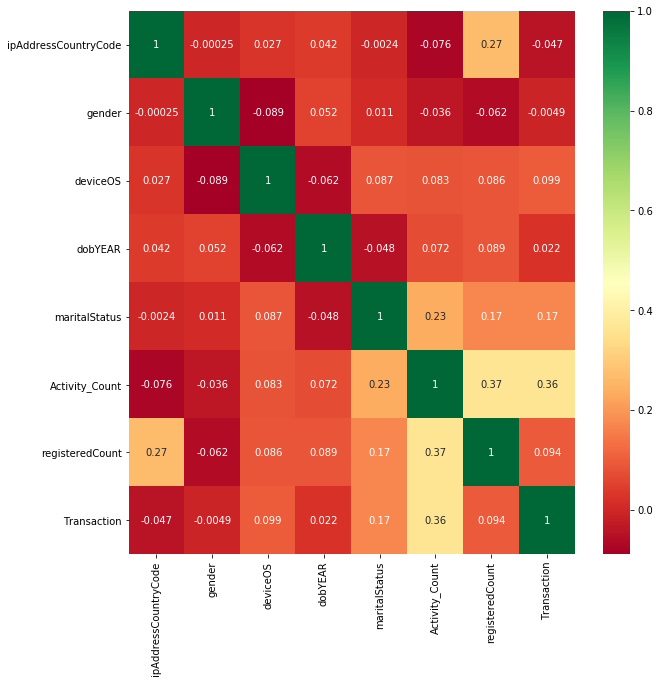

In [204]:
corrfeatures = ["ipAddressCountryCode","gender","deviceOS","dobYEAR","maritalStatus","Activity_Count","registeredCount","Transaction"]
#X = pd.get_dummies(train[features])"
X_corr = (memberstotal[corrfeatures])
corrmat = X_corr.corr()
top_corr_features = corrmat.index[abs(corrmat["Transaction"])>=0]
plt.figure(figsize=(10,10))
g = sn.heatmap(memberstotal[top_corr_features].corr(),annot=True,cmap="RdYlGn")

corrmat


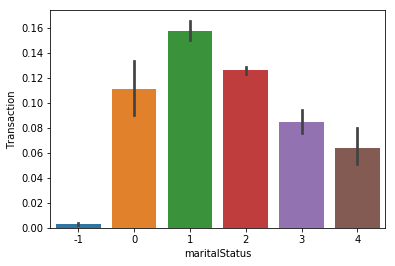

In [205]:
sn.barplot(memberstotal.maritalStatus,memberstotal.Transaction)

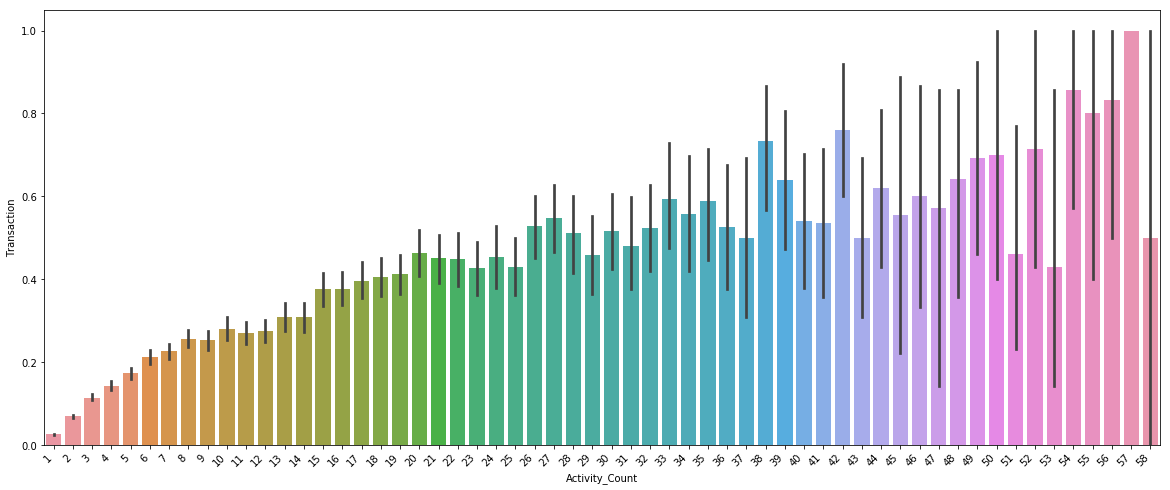

In [15]:
plt.figure(figsize=(20,8))
chart = sn.barplot(memberstotal.Activity_Count,memberstotal.Transaction)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
print()

The most active users are more susceptible to do a purchase.

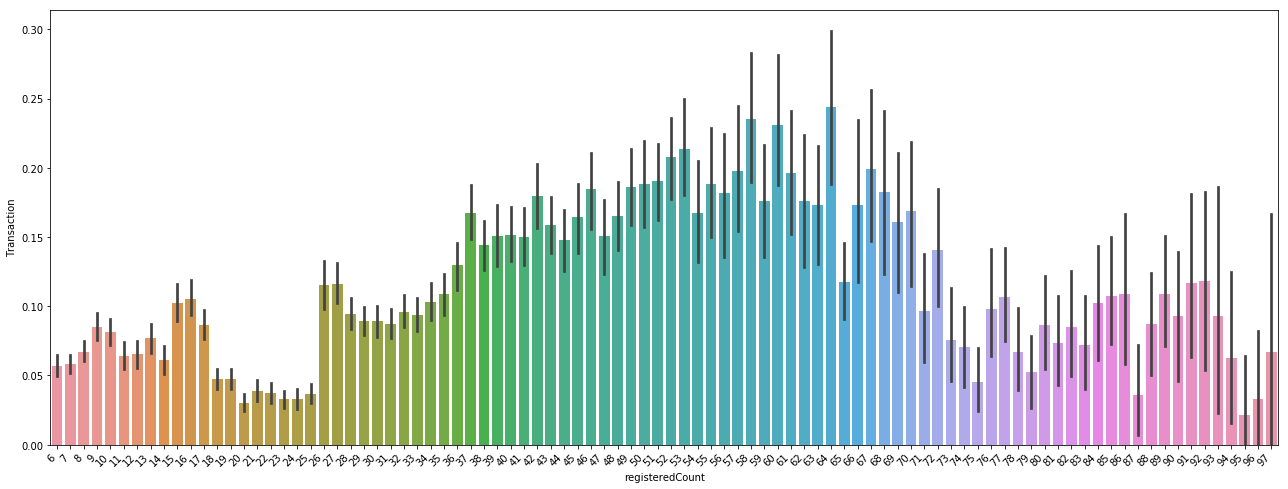

In [314]:
plt.figure(figsize=(22,8))
chart = sn.barplot(memberstotal.registeredCount,memberstotal.Transaction)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
print()

Members registered since at least 270 days ago or at the latest 2 years ago (730 days) were the one who did most of the purchases.

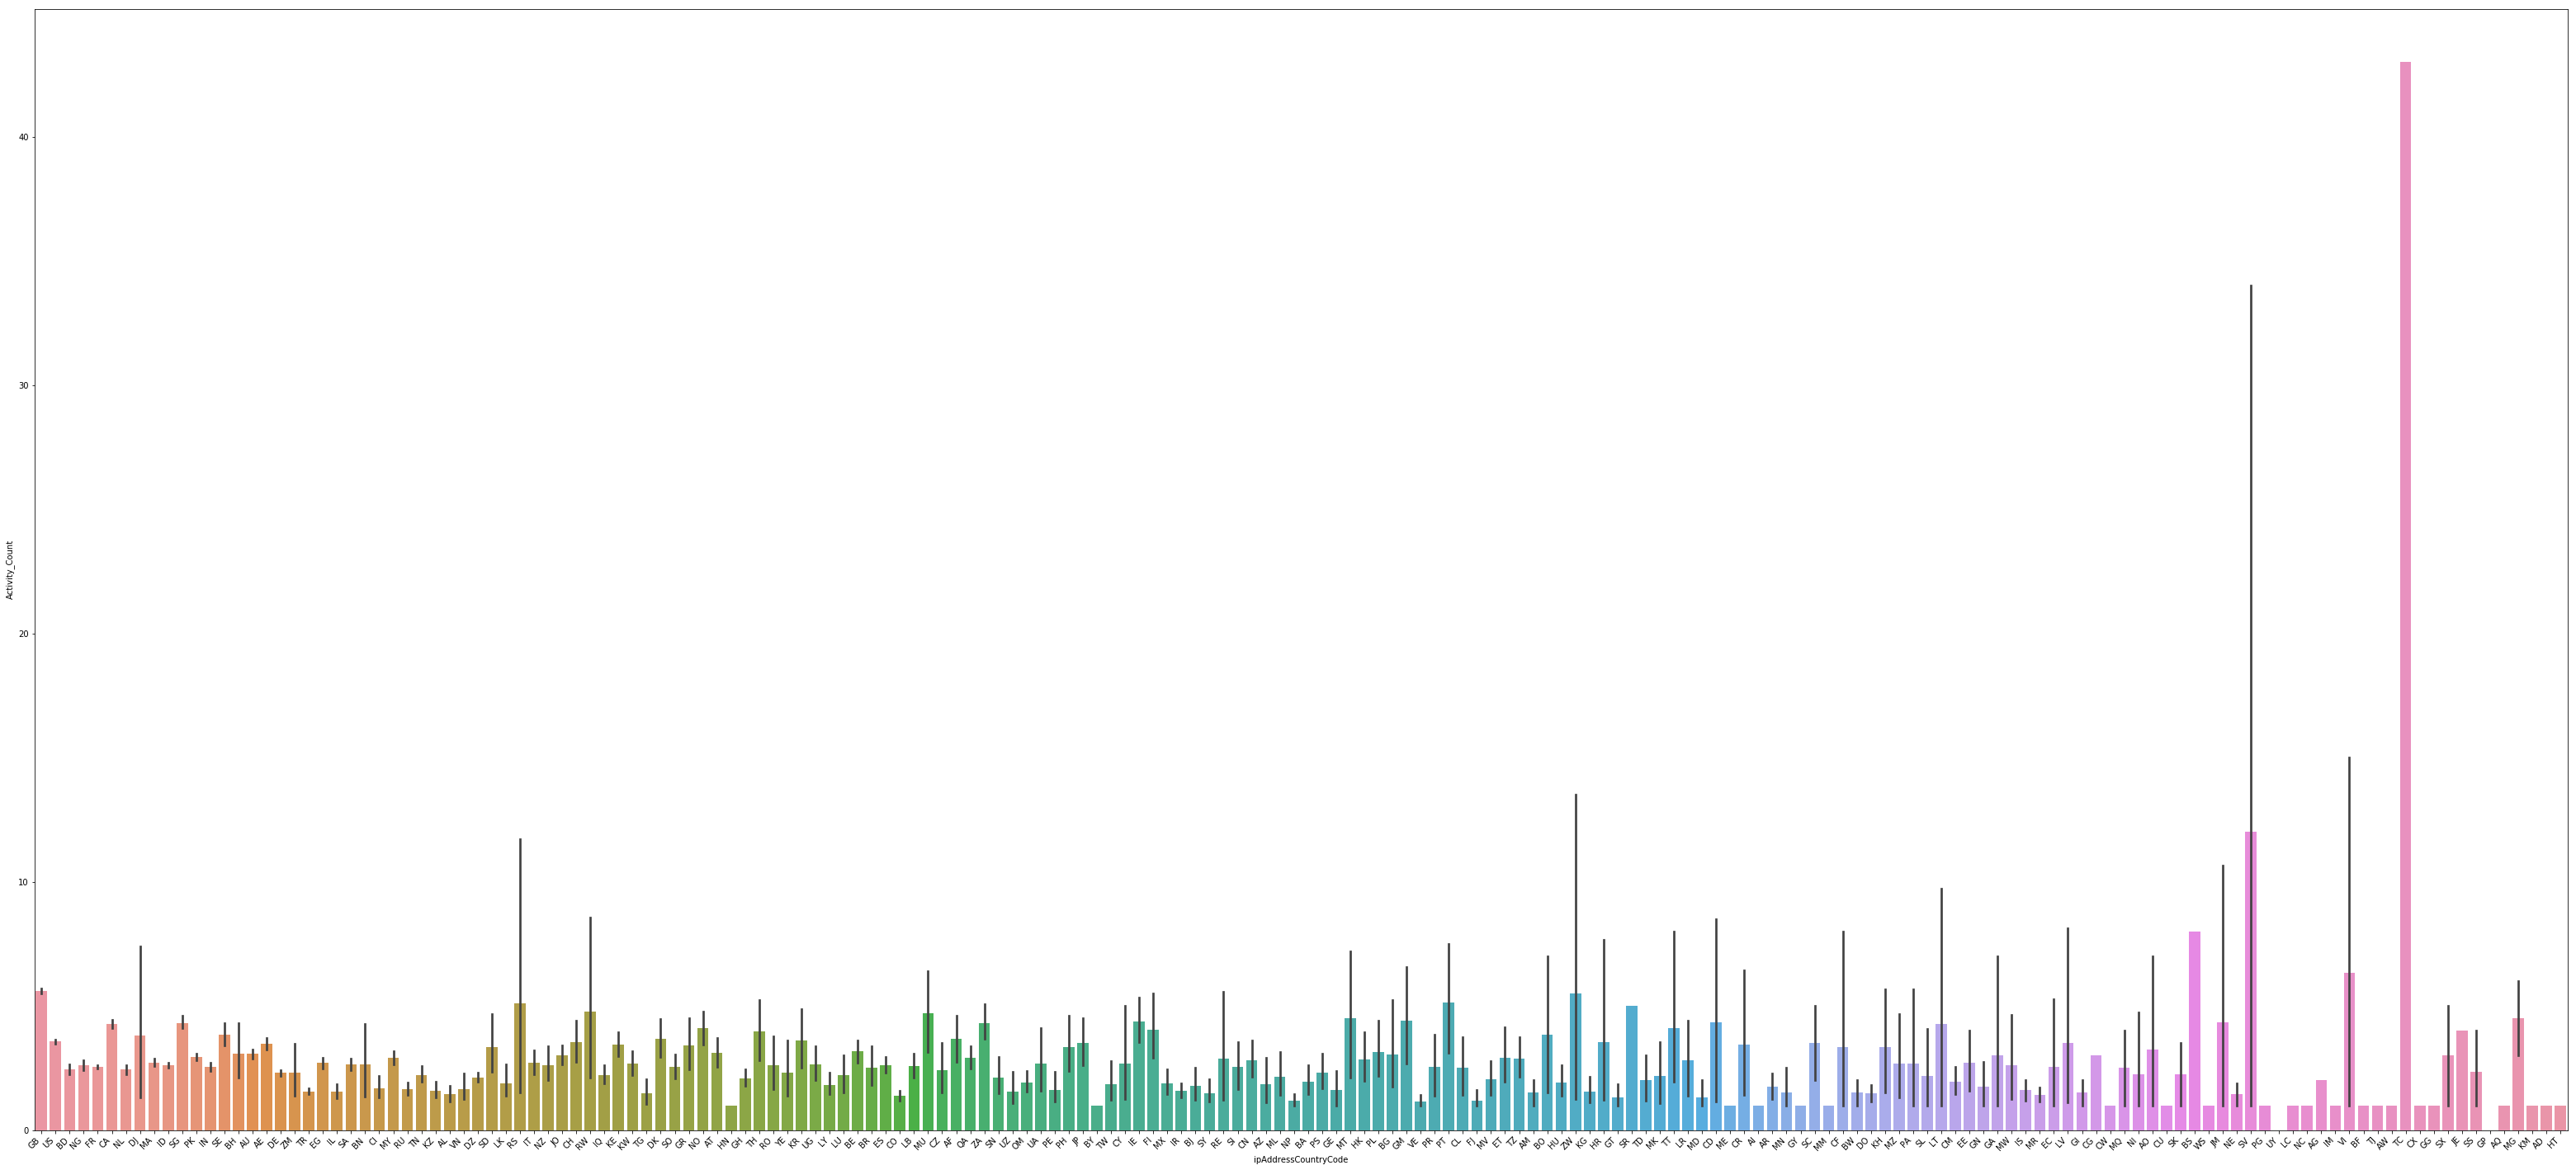

In [190]:
plt.figure(figsize=(55,25))
chart = sn.barplot(mcountry.ipAddressCountryCode,mcountry.Activity_Count)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
print()

Members in country with small muslim community are more active in Muzmatch.

### Neural Networks

To optimize the neural network i used the adam otpimizer and the dropout regularization.
I also did hyparameter tuning to find an effective kernel_utilializer.

In [161]:
memberstotal[['dobYEAR','ipAddressCountryCode','registeredCount','Activity_Count']] = scaler.fit_transform(memberstotal[['dobYEAR','ipAddressCountryCode','registeredCount','Activity_Count']])

In [214]:
X = memberstotal.drop(['Transaction','memberID','premium','Transactions_count'],axis=1)
Y = memberstotal[['Transaction']] 
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=42)

In [215]:
def train_model(trainX, trainy):
    #trainy = to_categorical(trainy)
    verbose, epochs, batch_size = 0, 40, 128
    n_row, n_features, n_outputs = trainX.shape[0], trainX.shape[1], 1
    
    model = Sequential()
    model.add(Dense(200, input_shape=((trainX.shape[1],)), kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(25, kernel_initializer='glorot_uniform', activation='relu'))
    #model.add(Dense(1, kernel_initializer='normal'))
    
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(trainX.values, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model
    

##### Time to execute the Neural Network : 

In [222]:
t0 = time.time()
modelMuz = train_model(X_train,Y_train)
t1 = time.time()
total = t1-t0
print('Time to do the training :',total,' s')

Time to do the training : 93.08122682571411  s


#### Evaluation :

Predictions of  : nb of members with at least one transaction : 50 
 
Metrics :  ['loss', 'accuracy']
[0.22675430212860032, 0.9109739065170288]
50


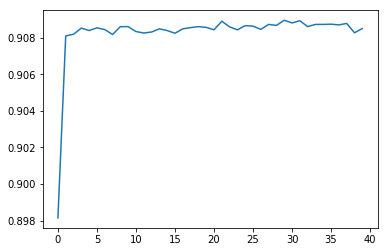

In [224]:
ypred = modelMuz.predict_classes(X_test)
print('Predictions of  : nb of members with at least one transaction :',ypred.sum(),'\n ')
print('Metrics : ', modelMuz.metrics_names)
print(ev)
ypred = modelMuz.predict_classes(X_test)
print(ypred.sum())
plt.plot(modelMuz.history.history['accuracy'])
plt.show()

In [218]:
scores = list()
k = 10
data = memberstotal.drop(['Transaction','memberID','premium','Transactions_count'],axis=1)
for i in range(k):
    X_ktrain, X_ktest, Y_ktrain, Y_ktest = train_test_split( X, Y, test_size=0.3, random_state=i)
    modelM = modelMuz.fit(X_ktrain, Y_ktrain)
    ypred = modelMuz.predict_classes(X_ktest)
    accuracy_score(Y_test, y_pred)

Epoch 1/1
74460/74460 [==============================] - 5s 62us/step - loss: 0.2414 - accuracy: 0.9085
Epoch 1/1
74460/74460 [==============================] - 5s 66us/step - loss: 0.2425 - accuracy: 0.9083
Epoch 1/1
74460/74460 [==============================] - 5s 68us/step - loss: 0.2392 - accuracy: 0.9094
Epoch 1/1
74460/74460 [==============================] - 5s 69us/step - loss: 0.2403 - accuracy: 0.9091
Epoch 1/1
74460/74460 [==============================] - 5s 69us/step - loss: 0.2411 - accuracy: 0.9082
Epoch 1/1
74460/74460 [==============================] - 5s 67us/step - loss: 0.2401 - accuracy: 0.9091
Epoch 1/1
74460/74460 [==============================] - 5s 64us/step - loss: 0.2408 - accuracy: 0.9082
Epoch 1/1
74460/74460 [==============================] - 4s 60us/step - loss: 0.2384 - accuracy: 0.9093
Epoch 1/1
74460/74460 [==============================] - 5s 63us/step - loss: 0.2383 - accuracy: 0.9102
Epoch 1/1
74460/74460 [==============================] - 5s 66us

## Hyperparameters Tuning

In [140]:
def create_model(init_mode='normal'):
    n_row, n_features, n_outputs = X_train.shape[0], X_train.shape[1], 1
    
    model = Sequential()
    model.add(Dense(200, input_shape=((X_train.shape[1],)), kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(100, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(25, kernel_initializer=init_mode, activation='relu'))
    #model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
    
    return model

In [141]:
model_CV = KerasClassifier(build_fn=create_model, epochs=20, 
                           batch_size=128, verbose=0)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9092532992362976 using {'init_mode': 'glorot_normal'}
 mean=0.908, std=0.0007417 using {'init_mode': 'uniform'}
 mean=0.9088, std=0.0002967 using {'init_mode': 'lecun_uniform'}
 mean=0.9082, std=0.0008114 using {'init_mode': 'normal'}
 mean=0.908, std=0.0007417 using {'init_mode': 'zero'}
 mean=0.9093, std=0.0009816 using {'init_mode': 'glorot_normal'}
 mean=0.9083, std=0.000913 using {'init_mode': 'glorot_uniform'}
 mean=0.9082, std=0.0007833 using {'init_mode': 'he_normal'}
 mean=0.9084, std=0.001144 using {'init_mode': 'he_uniform'}


Thus the best kernel_initializer here is the "glorot_normal".

# Comparaison of differents models

In [219]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

warnings.filterwarnings('ignore')

models = []
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("KNN",KNeighborsClassifier()))


for name,model in models:
    print(name)
    model = model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print('Nb of members with a transaction predicted : ',y_pred.sum())
    cv_result = cross_val_score(model,X,Y, cv = 5,scoring = "accuracy")
    #score = accuracy_score(Y_test, y_pred)
    print(cv_result)
    print('Average score = ',cv_result.sum()/5)
    print()

Dtree
Nb of members with a transaction predicted :  2983
[0.11562324 0.11436495 0.35949986 0.35992291 0.90913791]
Average score =  0.37170977487567075

LR
Nb of members with a transaction predicted :  596
[0.84804475 0.91506064 0.90956097 0.90866786 0.90866786]
Average score =  0.8980004128091521

NB
Nb of members with a transaction predicted :  2301
[0.40515134 0.88540002 0.91609476 0.91482561 0.90843283]
Average score =  0.8059809128260931

RF
Nb of members with a transaction predicted :  1429
[0.12037037 0.26736862 0.56609006 0.55974429 0.90880887]
Average score =  0.4844764431631029

KNN
Nb of members with a transaction predicted :  1427
[0.17954503 0.42342766 0.65605904 0.75933064 0.90885588]
Average score =  0.5854436486786263



# Conclusion :

I choose to work on a ML algorithm to predict if a member will ever do a purchase or not. The algorithm will need more works to reduce the loss.

### Improvements to do :
#### On the Neural Network : 
Try differents Neural Network architecture, others methods of optimization, others numbers of hidden layers & units.
Work on others hyperparameters : learning_rate, batch_size. Use keras tuning method.

#### On the Dataset : 
There is multiple opportunities with the dataset :
For the ipAddressCountryCode missing, we can use the currency if the member did a transaction to guess the Country.
Also, focus the work on Countries with most active members like UK for example. (although members from small country & with small muslim communities can also be active)
One interesting metric would be the "match" ratio, as less succesful members are more expected to purchase Muzmatch premium & others services.

While my model is focused on guessing if a member will do a transaction, it could also be used to guess the numbers of transactions per user.

## Business Value

If the model predict than one user can do a purchase, we should send him more ads or even a discount especially about the premium which is the most used product. The analyctics also show the importance of the activity frequence

Overall the most likely people who will purchase are the one using Iphone, are male and active on the application.
So the marketing campaign shoud focus towards theses people. (refSource:store being the higher in the analytics, the ads should increase in the mobile application )